### Mount Google Drive and setup paths

In [1]:
import os
import sys

from google.colab import drive

DRIVE_MOUNT_PATH = '/content/drive'
drive.mount(DRIVE_MOUNT_PATH)

PRJ_DIR = os.path.join(DRIVE_MOUNT_PATH, 'My Drive/yyColab/1st-DL-CVMarathon')
sys.path.append(PRJ_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

請根據 Lena 圖做以下處理

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = os.path.join(PRJ_DIR, 'data/lena.png')
img = cv2.imread(img_path)

## Hint: 矩形

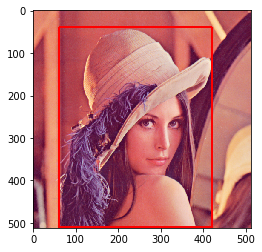

In [3]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (0, 0, 255), 3)

plt.imshow(img_rect[:, :, ::-1])
plt.show()

## Hint: 線

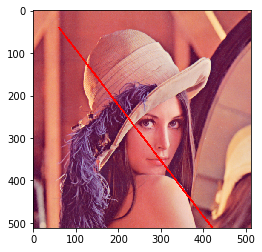

In [4]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 3)

plt.imshow(img_line[:, :, ::-1])
plt.show()

## Hint: 文字

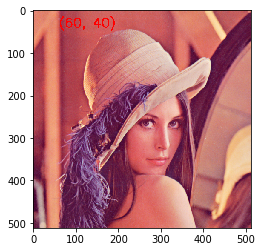

In [5]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (0, 0, 255), 2)

plt.imshow(img_text[:, :, ::-1])
plt.show()

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

origin point1=[452, 40], origin point2=[92, 510]
resize point1=(226, 20), resize point2=(46, 255)


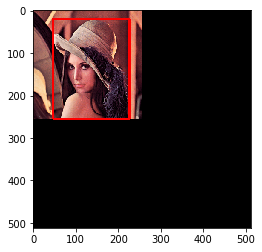

In [6]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[..., -1] = cv2.equalizeHist(img_hw[..., -1])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像
"""
h, w = img_hw.shape[:2]

# 圖片鏡像
img_hw = img_hw[:, ::-1, :]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1[0] = img_hw.shape[1] - point1[0]
point2[0] = img_hw.shape[0] - point2[0]

"""
縮放處理 (0.5 倍)
"""
fx = 0.5
fy = 0.5
resize_col = int(img_hw.shape[1]*fx)
resize_row = int(img_hw.shape[0]*fy)

# 建構 scale matrix
M_scale = np.array([[fx, 0, 0], [0, fy, 0]])
img_hw = cv2.warpAffine(img_hw, M_scale, (img_hw.shape[1], img_hw.shape[0]))

# 把左上跟右下轉為矩陣型式
bbox = np.array((point1, point2), dtype=np.float32)
#print('M_scale.shape={}, bbox.shape={}'.format(M_scale.shape, bbox.shape))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
homo_coor_result = np.dot(M_scale.T, bbox)
homo_coor_result = homo_coor_result.astype('uint8')
#print(homo_coor_result)
scale_point1 = tuple(homo_coor_result[0])
scale_point2 = tuple(homo_coor_result[1])
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

# 畫圖
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 3)

plt.imshow(img_hw[:, :, ::-1])
plt.show()

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional